In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregar os dados
data = pd.read_csv('./data/indexProcessed.csv')

# Pré-processamento dos dados
prices = data['Close'].values.astype(float)
prices = prices.reshape(-1, 1)  # Reshape para (n_samples, 1)

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_normalized = scaler.fit_transform(prices)

In [3]:
# Dividir os dados em sequências de entrada e saída
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append((seq, label))
    return sequences

seq_length = 10
sequences = create_sequences(prices_normalized, seq_length)

# Dividir os dados em conjuntos de treinamento e teste
split_ratio = 0.8
split = int(split_ratio * len(sequences))
train_data = sequences[:split]
test_data = sequences[split:]

In [4]:
# Definir o modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 32
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

# Definir a função de perda e otimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Treinar o modelo
num_epochs = 20
for epoch in range(num_epochs):
    for seq, labels in train_data:
        seq = torch.FloatTensor(seq).unsqueeze(0)
        labels = torch.FloatTensor(labels)
        
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}ß')

Epoch [1/20], Loss: 1.4430524970521219e-05ß
Epoch [2/20], Loss: 1.1210931916139089e-06ß
Epoch [3/20], Loss: 3.7198353197709366e-07ß
Epoch [4/20], Loss: 3.243557387122564e-07ß
Epoch [5/20], Loss: 3.127833565486071e-07ß
Epoch [6/20], Loss: 2.994609360484901e-07ß
Epoch [7/20], Loss: 2.6853410872718086e-07ß
Epoch [8/20], Loss: 2.32087444373974e-07ß
Epoch [9/20], Loss: 1.9197869960407843e-07ß
Epoch [10/20], Loss: 1.5480310366911e-07ß
Epoch [11/20], Loss: 1.2495189594119438e-07ß
Epoch [12/20], Loss: 1.0058812449642573e-07ß
Epoch [13/20], Loss: 8.250381711150112e-08ß
Epoch [14/20], Loss: 6.83279566260353e-08ß
Epoch [15/20], Loss: 5.7413274134887615e-08ß
Epoch [16/20], Loss: 4.90186025103867e-08ß
Epoch [17/20], Loss: 4.189486446648516e-08ß
Epoch [18/20], Loss: 3.609612519994698e-08ß
Epoch [19/20], Loss: 3.1348683648957376e-08ß
Epoch [20/20], Loss: 2.7555646653354415e-08ß


In [6]:
# Avaliar o modelo
model.eval()
predictions = []
with torch.no_grad():
    for seq, _ in test_data:
        seq = torch.FloatTensor(seq).unsqueeze(0)
        pred = model(seq).item()
        predictions.append(pred)

# Desnormalizar as previsões
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

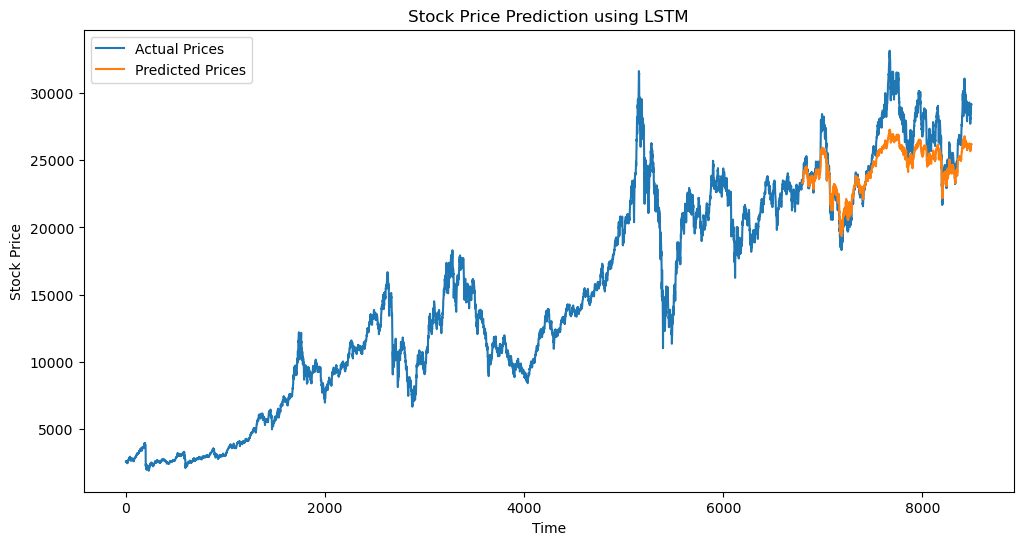

In [7]:
# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].values, label='Actual Prices')
plt.plot(np.arange(split+seq_length, len(data['Close'])), predictions, label='Predicted Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()